sphere function using real coded GA

Best Solution: [-0.06105877  0.08002305  0.02101044 -0.01328275]
Best Fitness (Minimum Value): 0.010749731761072754


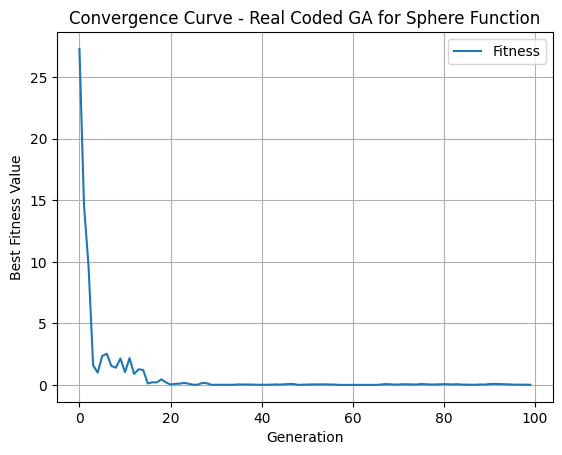

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# Sphere function
def sphere_function(x):
    return np.sum(x ** 2)

# GA parameters
pop_size = 50
num_generations = 100
num_variables = 4
lower_bound = -10
upper_bound = 10
mutation_rate = 0.1
crossover_rate = 0.9

# Initialize population
population = np.random.uniform(lower_bound, upper_bound, (pop_size, num_variables))

# To store best fitness per generation
convergence = []

# Run GA
for gen in range(num_generations):
    fitness = np.array([sphere_function(ind) for ind in population])
    best_idx = np.argmin(fitness)
    best_solution = population[best_idx]
    best_fitness = fitness[best_idx]
    convergence.append(best_fitness)

    # Tournament selection
    selected = []
    for _ in range(pop_size):
        i, j = np.random.randint(0, pop_size, 2)
        selected.append(population[i] if fitness[i] < fitness[j] else population[j])
    selected = np.array(selected)

    # Simulated Binary Crossover (SBX)
    offspring = []
    for i in range(0, pop_size, 2):
        parent1, parent2 = selected[i], selected[i+1]
        if np.random.rand() < crossover_rate:
            child1, child2 = np.empty(num_variables), np.empty(num_variables)
            for j in range(num_variables):
                u = np.random.rand()
                beta = (2 * u) ** (1 / 2) if u <= 0.5 else (1 / (2 * (1 - u))) ** (1 / 2)
                child1[j] = 0.5 * ((1 + beta) * parent1[j] + (1 - beta) * parent2[j])
                child2[j] = 0.5 * ((1 - beta) * parent1[j] + (1 + beta) * parent2[j])
            offspring.extend([child1, child2])
        else:
            offspring.extend([parent1, parent2])
    offspring = np.clip(offspring, lower_bound, upper_bound)

    # Polynomial Mutation
    for i in range(pop_size):
        for j in range(num_variables):
            if np.random.rand() < mutation_rate:
                u = np.random.rand()
                delta = (2 * u) ** (1 / (1 + 20)) - 1 if u < 0.5 else 1 - (2 * (1 - u)) ** (1 / (1 + 20))
                offspring[i][j] += delta * (upper_bound - lower_bound)
    population = np.clip(offspring, lower_bound, upper_bound)

# Final result
final_fitness = np.array([sphere_function(ind) for ind in population])
best_idx = np.argmin(final_fitness)
best_solution = population[best_idx]
best_value = final_fitness[best_idx]

print("Best Solution:", best_solution)
print("Best Fitness (Minimum Value):", best_value)

# Plot convergence
plt.plot(convergence, label="Fitness")
plt.title("Convergence Curve - Real Coded GA for Sphere Function")
plt.xlabel("Generation")
plt.ylabel("Best Fitness Value")
plt.legend()
plt.grid(True)
plt.show()


GAP using real coded GA

In [44]:
import os
import numpy as np
import random
from deap import base, creator, tools, algorithms
import csv
import re

# === GA Parameters ===
POP_SIZE = 100
GENS = 200
CX_PROB = 0.9
MUT_PROB = 0.05
TOURN_SIZE = 3

GAP_FOLDER = r"C:\Users\MD KAIF\Desktop\assignment4_soln\gap_dataset_files"

# === GAP File Parser ===
def parse_gap_file(filepath):
    with open(filepath, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    index = 0
    num_instances = int(lines[index])
    index += 1
    instances = []
    for _ in range(num_instances):
        m, n = map(int, lines[index].split())
        index += 1
        util = []
        for _ in range(m):
            row = []
            while len(row) < n:
                row += list(map(int, lines[index].split()))
                index += 1
            util.append(row)
        res = []
        for _ in range(m):
            row = []
            while len(row) < n:
                row += list(map(int, lines[index].split()))
                index += 1
            res.append(row)
        cap = []
        while len(cap) < m:
            cap += list(map(int, lines[index].split()))
            index += 1
        instances.append((m, n, np.array(util), np.array(res), np.array(cap)))
    return instances

# === Decode and Repair ===
def decode(ind, n_users, m_servers):
    return [int(gene) % m_servers for gene in ind]

def repair_allocation(alloc, res, cap):
    m, n = res.shape
    usage = np.zeros(m)
    for u, s in enumerate(alloc):
        usage[s] += res[s][u]
    for s in range(m):
        if usage[s] > cap[s]:
            for u in range(n):
                if alloc[u] == s:
                    for new_s in range(m):
                        if new_s != s and usage[new_s] + res[new_s][u] <= cap[new_s]:
                            usage[s] -= res[s][u]
                            usage[new_s] += res[new_s][u]
                            alloc[u] = new_s
                            break
                    if usage[s] <= cap[s]:
                        break
    return alloc, usage

# === Evaluation Function ===
def evaluate(ind, m, n, util, res, cap):
    alloc = decode(ind, n, m)
    alloc, usage = repair_allocation(alloc, res, cap)
    for s in range(m):
        if usage[s] > cap[s]:
            return 0,
    total = sum(util[alloc[u]][u] for u in range(n))
    return total,

# === Real-Coded GA Solver ===
def solve_gap_instance(m, n, util, res, cap, track_convergence=False):
    chrom_len = n
    if not hasattr(creator, "FitnessMax"):
        creator.create("FitnessMax", base.Fitness, weights=(1.0,))
    if not hasattr(creator, "Individual"):
        creator.create("Individual", list, fitness=creator.FitnessMax)

    toolbox = base.Toolbox()
    toolbox.register("attr_float", random.uniform, 0, m-1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, chrom_len)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)

    toolbox.register("mate", tools.cxBlend, alpha=0.5)
    toolbox.register("mutate", tools.mutGaussian, mu=0, sigma=1.0, indpb=0.2)
    toolbox.register("select", tools.selTournament, tournsize=TOURN_SIZE)
    toolbox.register("evaluate", evaluate, m=m, n=n, util=util, res=res, cap=cap)

    pop = toolbox.population(n=POP_SIZE)
    convergence = []
    best_so_far = 0

    for gen in range(GENS):
        offspring = algorithms.varAnd(pop, toolbox, cxpb=CX_PROB, mutpb=MUT_PROB)
        fits = list(map(toolbox.evaluate, offspring))
        for ind, fit in zip(offspring, fits):
            ind.fitness.values = fit
        pop = toolbox.select(offspring, k=len(pop))
        
        gen_best = max(ind.fitness.values[0] for ind in pop)
        if gen_best > best_so_far:
            best_so_far = gen_best
        if track_convergence:
            convergence.append(best_so_far)

    best = tools.selBest(pop, k=1)[0]
    best_alloc = decode(best, n, m)
    best_alloc, usage = repair_allocation(best_alloc, res, cap)
    total = sum(util[best_alloc[u]][u] for u in range(n))

    if track_convergence:
        return best_alloc, total, convergence
    else:
        return best_alloc, total

# === Sort Key ===
def sort_key(filename):
    match = re.search(r'\d+', filename)
    return int(match.group()) if match else float('inf')

# === Run All Files ===
def run_all_gap_files(folder_path):
    real_ga_results = []
    convergence_log = []

    for file in sorted(os.listdir(folder_path), key=sort_key):
        if file.endswith(".txt"):
            filepath = os.path.join(folder_path, file)
            instances = parse_gap_file(filepath)

            for idx, (m, n, util, res, cap) in enumerate(instances):
                try:
                    best_alloc, total, convergence = solve_gap_instance(m, n, util, res, cap, track_convergence=True)
                    print(f"✅ Instance {idx + 1} from {file}")
                    print(f"Assignment: {best_alloc}")
                    print(f"Total Utility: {total}\n")
                    real_ga_results.append((file, idx + 1, best_alloc, total))

                    # Save convergence for GAP12 instance only
                    if file == "gap12.txt" and idx == len(instances) - 1:
                        conv_path = os.path.join(folder_path, "real_ga_convergence_gap12.csv")
                        with open(conv_path, 'w', newline='') as f:
                            writer = csv.writer(f)
                            writer.writerow(["Generation", "Best So Far"])
                            for gen, val in enumerate(convergence):
                                writer.writerow([gen + 1, val])
                        print(f"📈 Convergence for GAP12 saved to {conv_path}")
                except Exception as e:
                    print(f"⚠️ Error in {file} Instance {idx + 1}: {e}")

    # Final results
    output_path = os.path.join(folder_path, "real_ga_results.csv")
    with open(output_path, 'w', newline='') as f:
        writer = csv.writer(f)
        writer.writerow(["Filename", "Instance", "Assignments", "Total Utility"])
        for row in real_ga_results:
            writer.writerow(row)
    print(f"\n✅ Final results saved to {output_path}")

# === Run ===
run_all_gap_files(GAP_FOLDER)


✅ Instance 1 from gap1.txt
Assignment: [0, 3, 2, 1, 0, 3, 1, 4, 0, 2, 4, 3, 4, 0, 2]
Total Utility: 292

✅ Instance 2 from gap1.txt
Assignment: [4, 3, 2, 2, 4, 4, 2, 1, 1, 0, 1, 1, 3, 0, 3]
Total Utility: 307

✅ Instance 3 from gap1.txt
Assignment: [3, 1, 1, 4, 1, 2, 3, 4, 3, 1, 2, 0, 0, 2, 0]
Total Utility: 306

✅ Instance 4 from gap1.txt
Assignment: [1, 2, 2, 2, 0, 0, 3, 1, 4, 3, 1, 2, 0, 4, 3]
Total Utility: 305

✅ Instance 5 from gap1.txt
Assignment: [4, 4, 0, 2, 1, 4, 4, 1, 0, 1, 2, 3, 3, 4, 0]
Total Utility: 309

✅ Instance 1 from gap2.txt
Assignment: [4, 3, 0, 4, 3, 0, 1, 2, 2, 3, 4, 1, 3, 0, 1, 2, 2, 3, 1, 0]
Total Utility: 366

✅ Instance 2 from gap2.txt
Assignment: [0, 2, 2, 0, 2, 2, 1, 1, 4, 4, 4, 3, 1, 1, 3, 3, 3, 3, 1, 0]
Total Utility: 368

✅ Instance 3 from gap2.txt
Assignment: [3, 4, 0, 0, 1, 1, 2, 1, 4, 4, 0, 1, 3, 3, 0, 2, 2, 3, 0, 2]
Total Utility: 389

✅ Instance 4 from gap2.txt
Assignment: [3, 2, 2, 2, 2, 0, 4, 0, 0, 3, 4, 3, 3, 0, 1, 4, 1, 0, 1, 2]
Total Utility: 

now plotting the graph comparing different methods

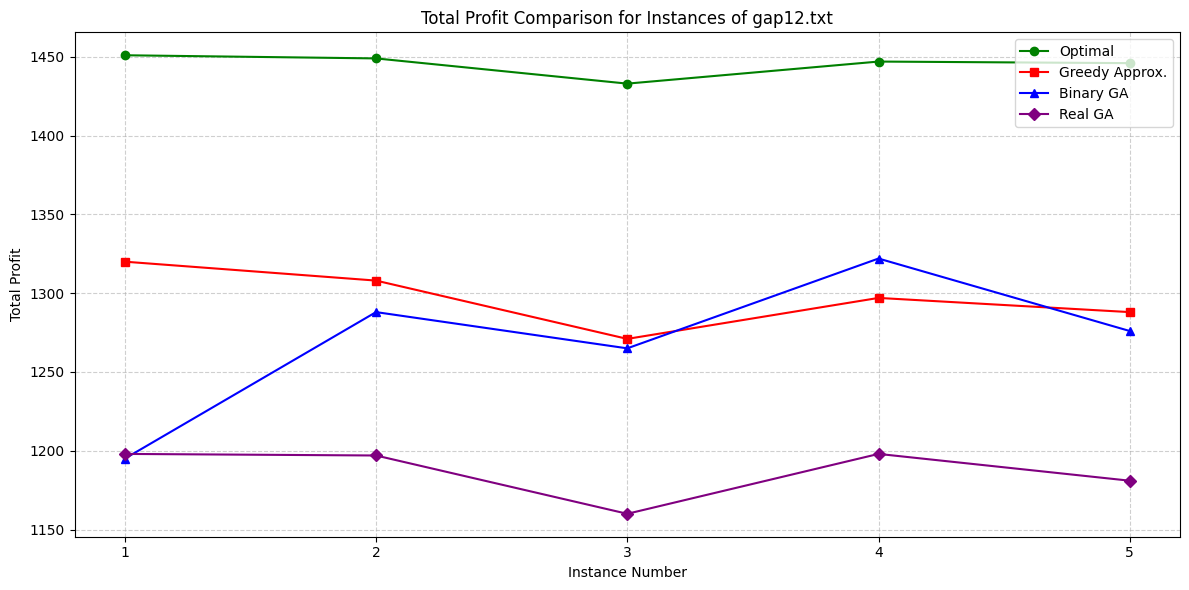


✅ Plot saved successfully at: c:\Users\MD KAIF\Desktop\assignment4_soln\gap12_comparison_with_real_ga.png


In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# File paths
optimal_file = r"C:\Users\MD KAIF\Desktop\assignment4_soln\optimal_results.csv"
approximate_file = r"C:\Users\MD KAIF\Desktop\assignment4_soln\greedy_results.csv"
binary_file = r"C:\Users\MD KAIF\Desktop\assignment4_soln\binary_ga_results.csv"
real_ga_file = r"C:\Users\MD KAIF\Desktop\assignment4_soln\real_ga_results.csv"

# Load and clean CSVs
def load_and_clean_csv(path, file_col='Filename', profit_col='Total_Profit'):
    df = pd.read_csv(path)
    df.columns = df.columns.str.strip()
    if file_col in df.columns:
        df[file_col] = df[file_col].astype(str).str.strip()
    if 'Instance' in df.columns:
        df['Instance'] = pd.to_numeric(df['Instance'], errors='coerce').astype('Int64')
    if profit_col in df.columns:
        df[profit_col] = df[profit_col].astype(str).str.replace(',', '').astype(float)
    return df

df_optimal = load_and_clean_csv(optimal_file)
df_approx = load_and_clean_csv(approximate_file)
df_binary = load_and_clean_csv(binary_file)
df_real = load_and_clean_csv(real_ga_file, file_col='File', profit_col='Total profit')

# Filter for gap12.txt
filename = 'gap12.txt'
df_optimal_gap12 = df_optimal[df_optimal['Filename'] == filename]
df_approx_gap12 = df_approx[df_approx['Filename'] == filename]
df_binary_gap12 = df_binary[df_binary['Filename'] == filename]
df_real_gap12 = df_real[df_real['File'] == filename]

# Get common instances
common_instances = sorted(
    set(df_optimal_gap12['Instance'].dropna()) &
    set(df_approx_gap12['Instance'].dropna()) &
    set(df_binary_gap12['Instance'].dropna()) &
    set(df_real_gap12['Instance'].dropna())
)

# Extract values
optimal_values = [df_optimal_gap12[df_optimal_gap12['Instance'] == i]['Total_Profit'].values[0] for i in common_instances]
approx_values = [df_approx_gap12[df_approx_gap12['Instance'] == i]['Total_Profit'].values[0] for i in common_instances]
binary_values = [df_binary_gap12[df_binary_gap12['Instance'] == i]['Total_Profit'].values[0] for i in common_instances]
real_values = [df_real_gap12[df_real_gap12['Instance'] == i]['Total profit'].values[0] for i in common_instances]

# Plot
plt.figure(figsize=(12, 6))
plt.plot(common_instances, optimal_values, marker='o', label='Optimal', color='green')
plt.plot(common_instances, approx_values, marker='s', label='Greedy Approx.', color='red')
plt.plot(common_instances, binary_values, marker='^', label='Binary GA', color='blue')
plt.plot(common_instances, real_values, marker='D', label='Real GA', color='purple')

plt.title('Total Profit Comparison for Instances of gap12.txt')
plt.xlabel('Instance Number')
plt.ylabel('Total Profit')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.xticks(common_instances)
plt.tight_layout()

# Save plot
output_path = os.path.join(os.getcwd(), "gap12_comparison_with_real_ga.png")
plt.savefig(output_path, dpi=300)
plt.show()

print(f"\n✅ Plot saved successfully at: {output_path}")


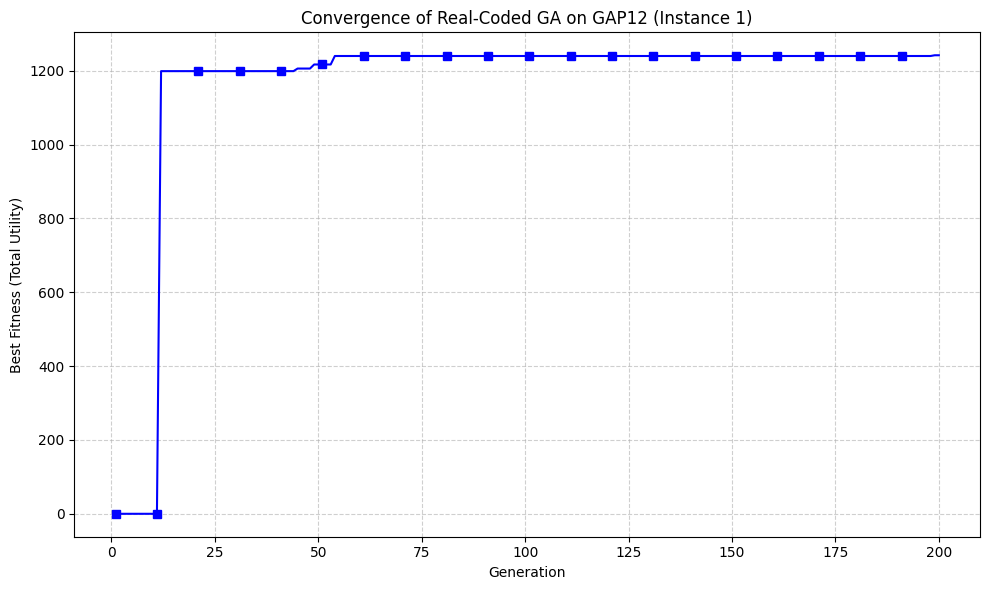


✅ Real GA convergence plot saved at: c:\Users\MD KAIF\Desktop\assignment4_soln\gap12_real_convergence_plot.png


In [45]:
import matplotlib.pyplot as plt
import os

# === Load GAP12 Instance ===
gap12_file = r"C:\Users\MD KAIF\Desktop\assignment4_soln\gap_dataset_files\gap12.txt"
instances = parse_gap_file(gap12_file)
m, n, util, res, cap = instances[0]  # Use the first instance from GAP12

# === Run Real-Coded GA with Convergence Tracking ===
_, _, real_convergence = solve_gap_instance(m, n, util, res, cap, track_convergence=True)

# === Plot Convergence ===
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(real_convergence) + 1), real_convergence, color='blue', marker='s', markevery=10)

plt.title("Convergence of Real-Coded GA on GAP12 (Instance 1)")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Total Utility)")
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# === Save Plot ===
output_path = os.path.join(os.getcwd(), "gap12_real_convergence_plot.png")
plt.savefig(output_path, dpi=300)
plt.show()

print(f"\n✅ Real GA convergence plot saved at: {output_path}")


In [ ]:
import pandas as pd

# Save convergence list to CSV
binary_df = pd.DataFrame({'Generation': list(range(1, len(convergence_log)+1)),
                          'Fitness': convergence_log})
binary_df.to_csv(r"C:\Users\MD KAIF\Desktop\assignment4_soln\real_ga_convergence_gap12.csv", index=False)
print("✅ real GA convergence saved.")

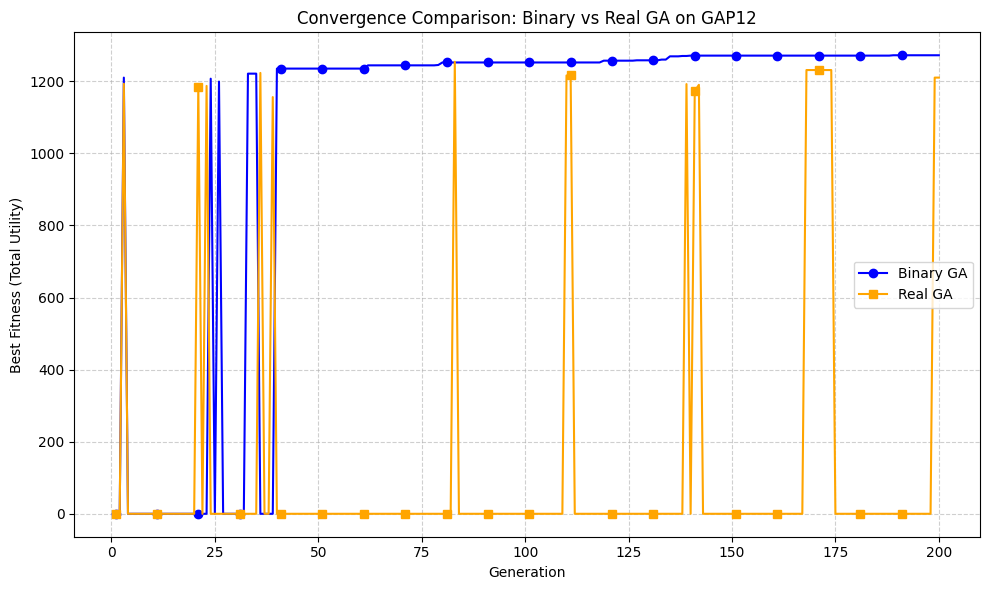


✅ Comparison plot saved at: c:\Users\MD KAIF\Desktop\assignment4_soln\gap12_convergence_binary_vs_real.png


In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import os

# Load CSVs
binary_df = pd.read_csv(r"C:\Users\MD KAIF\Desktop\assignment4_soln\binary_ga_convergence_gap12.csv")
real_df = pd.read_csv(r"C:\Users\MD KAIF\Desktop\assignment4_soln\real_ga_convergence_gap12.csv")

# Plot
plt.figure(figsize=(10, 6))
plt.plot(binary_df['Generation'], binary_df['Fitness'], label='Binary GA', color='blue', marker='o', markevery=10)
plt.plot(real_df['Generation'], real_df['Fitness'], label='Real GA', color='orange', marker='s', markevery=10)

plt.title("Convergence Comparison: Binary vs Real GA on GAP12")
plt.xlabel("Generation")
plt.ylabel("Best Fitness (Total Utility)")
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save plot
output_path = os.path.join(os.getcwd(), "gap12_convergence_binary_vs_real.png")
plt.savefig(output_path, dpi=300)
plt.show()

print(f"\n✅ Comparison plot saved at: {output_path}")
